## packages

In [276]:
# import libraries
import requests
import time
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import holoviews as hv
from holoviews import opts, dim
%load_ext rpy2.ipython

%R library(circlize)
%R library(RColorBrewer)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['RColorBrewer', 'circlize', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U12')

## website scraping

In [113]:
shipsDate = []
for i in range(1,776):
    #quote_page = f"https://archiveofourown.org/tags/Percy%20Jackson%20and%20the%20Olympians%20*a*%20Related%20Fandoms%20-%20All%20Media%20Types/works?commit=Sort+and+Filter&page={i}&utf8=%E2%9C%93&work_search%5Bcomplete%5D=&work_search%5Bcrossover%5D=F&work_search%5Bdate_from%5D=&work_search%5Bdate_to%5D=&work_search%5Bexcluded_tag_names%5D=&work_search%5Blanguage_id%5D=&work_search%5Bother_tag_names%5D=&work_search%5Bquery%5D=&work_search%5Bsort_column%5D=revised_at&work_search%5Bwords_from%5D=&work_search%5Bwords_to%5D="
    t0 = time.time()
    time.sleep(5)
    page = requests.get(quote_page)
    response_delay = time.time() - t0
    soup = BeautifulSoup(page.content, "html.parser")
    
    date = soup.find('p', attrs={'class': 'datetime'})
    date = date.text.strip()
    
    ships = soup.find_all('li', attrs={'class': 'relationships'})
    
    shipsList = []
    for i in range(0,len(ships)):
        shipsList.append(ships[i].text.strip())

    for i in shipsList:
        shipsDate.append([i,date])
    

NameError: name 'quote_page' is not defined

In [ ]:
df = pd.DataFrame(shipsDate, columns= ["Ship","Date"])

In [330]:
df.to_csv('output1.csv')

## start here after scraping

In [331]:
df = pd.read_csv('output1.csv')

In [332]:
pd.isnull(df).any(1).nonzero()[0]

array([    0,     1,     2, ..., 10581, 10582, 10583])

In [333]:
df = df[df['Ship'].str.contains('/')]

In [334]:
df['Ship'] = df['Ship'].str.replace(r"\(.*\)","")

In [335]:
individuals = df["Ship"].str.split("/", expand = True) 

personColumns = []
for i in range(0,7):
    df[f"Person {i+1}"] = individuals[i]
    personColumns.append(f"Person {i+1}")

df = df.reset_index(drop=True)

In [336]:
df.head()

,Unnamed: 0,Ship,Date,Person 1,Person 2,Person 3,Person 4,Person 5,Person 6,Person 7
0,0,Annabeth Chase/Percy Jackson,02 Apr 2019,Annabeth Chase,Percy Jackson,None,None,None,None,None
1,1,Nico di Angelo/Pollux,02 Apr 2019,Nico di Angelo,Pollux,None,None,None,None,None
2,2,Annabeth Chase/Percy Jackson,02 Apr 2019,Annabeth Chase,Percy Jackson,None,None,None,None,None
3,3,Annabeth Chase/Piper McLean,02 Apr 2019,Annabeth Chase,Piper McLean,None,None,None,None,None
4,4,Aphrodite/Ares,02 Apr 2019,Aphrodite,Ares,None,None,None,None,None


In [337]:
dfAnnabeth = df[df['Person 1'].str.contains("Annabeth")].copy()
dfAnnabeth['Person 1'].unique()
dfAnnabeth.loc[dfAnnabeth['Person 1'].str.contains('Annabeth', case=False), 'Person 1'] = 'Annabeth Chase'

In [338]:
mainCharacters = ['Percy', 'Annabeth', 'Grover', 'Leo' , 'Nico', 'Jason', 'Thalia', 
                  'Rachel', 'Bianca', 'Calypso' ,'Charles', 'Clarisse','Ethan',
                 'Juniper','Luke','Selena','Zo','Tyson','Will','Travis','Connor',
                 'Frank','Hazel','Octavian','Piper','Reyna','Magnus','Sam','Sally','Silena','Chris',
                  'Hylla','Drew','Frederick','Alex','Katie','Lou']
gods = ['Aphrodite','Ares','Athena','Chiron','Poseidon','Hera',
        'Hephaestus','Demeter','Zeus','Hades','Apollo','Artemis','Hestia','Hedge',
        'Persephone', 'Diana']

In [339]:
for i in personColumns:
    for j in range(0,len(mainCharacters)):
        df.loc[df[i].str.contains(mainCharacters[j], case=False, na=False), i] = mainCharacters[j]
        
    for k in range(0,len(gods)):
        df.loc[df[i].str.contains(gods[k], case=False, na=False), i] = gods[k]

    df.loc[df[i].str.contains('Original', case=False, na=False), i] = 'OC'

    df.loc[df[i].str.contains('Reader', case=False, na=False), i] = 'Reader'
    df.loc[df[i].str.contains('you', case=False, na=False), i] = 'Reader'

In [340]:
#threshold = 20
#toRemove = value_counts[value_counts <= threshold].index
#for i in personColumns:
#    df[i].replace(toRemove, np.nan, inplace=True)

In [341]:
value_counts = df[personColumns].stack().value_counts()

In [342]:
top50 = value_counts.index[:50].tolist()
top11 = value_counts.index[:11].tolist()

In [343]:
dfAdj = pd.DataFrame(index=top50, columns=top50)
dfAdj = dfAdj.fillna(0) # with 0s rather than NaNs

In [344]:
dfAdj.head(1)

,Nico,Percy,Will,Annabeth,Jason,Piper,Leo,Frank,Hazel,Reyna,...,Lou,Magnus,Hera,Ares,Alabaster Torrington,Cecil Markowitz,Hermes,Aphrodite,Sadie Kane,Kronos
Nico,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [345]:
for i in range(df.shape[0]):
    if df.at[i,'Person 1'] in top50 and df.at[i,'Person 2'] in top50:
        indexPerson = df.at[i,'Person 1']
        columnPerson = df.at[i,'Person 2']
        dfAdj.at[indexPerson, columnPerson] += 1

In [346]:
range(df.shape[1])

range(0, 10)

In [347]:
dfTest = pd.DataFrame(index=top50, columns=top50)
dfTest = dfTest.fillna(0)

In [348]:
df.at[3,'Person 1'] in top50

True

In [349]:
dfAdj.head()

,Nico,Percy,Will,Annabeth,Jason,Piper,Leo,Frank,Hazel,Reyna,...,Lou,Magnus,Hera,Ares,Alabaster Torrington,Cecil Markowitz,Hermes,Aphrodite,Sadie Kane,Kronos
Nico,0,589,2233,1,327,1,96,4,2,3,...,0,0,0,0,3,0,1,0,0,1
Percy,36,1,25,78,16,14,20,3,0,17,...,0,0,0,1,5,0,1,0,0,16
Will,62,1,0,0,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Annabeth,8,1514,0,0,24,167,3,0,4,60,...,0,0,0,0,0,0,0,0,0,0
Jason,10,397,24,0,0,738,95,3,0,63,...,0,0,2,0,0,0,0,0,0,0


## R chord

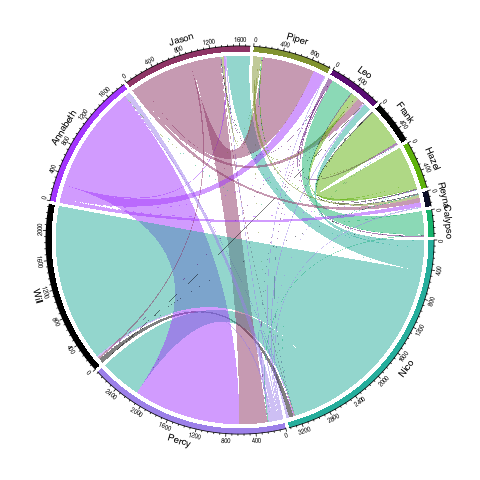

In [350]:
dfTop11 = dfAdj.iloc[:11]
dfTop11 = dfTop11[top50[:11]]

%R -i dfTop11
%R chordDiagram(dfTop11)
%R circos.clear()

# HoloViews Chord

In [351]:
dfChord = pd.DataFrame(columns=['source','target','value'], index = [0])

first = True
for i in top11:
    for j in top11:
        if i != j:
            hits = dfAdj.at[i,j]
            if first == True:
                dfChord.loc[0] = [i,j,hits]
                first = False
            else: 
                dfChord.loc[dfChord.index.max() + 1] = [i,j,hits]

In [352]:
dfChord.head()

,source,target,value
0,Nico,Percy,589
1,Nico,Will,2233
2,Nico,Annabeth,1
3,Nico,Jason,327
4,Nico,Piper,1


In [353]:
dfChord['value'] = dfChord['value'].astype(str).astype(int)
dfChord['value'].dtype

dtype('int64')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
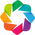

In [354]:
hv.extension('bokeh')
hv.output(size=200)

In [355]:
chord = hv.Chord(dfChord)
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
               labels='index', node_color=dim('index').str()))

:Chord   [source,target]   (value)